In [128]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [129]:
rawWhitesDF = pd.read_csv("raw-wine-data/winequality-white.csv", delimiter=";")
rawRedsDF = pd.read_csv("raw-wine-data/winequality-red.csv", delimiter=";")

In [130]:
rawWhitesDF.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [131]:
featureLabels = list(rawWhitesDF.columns.values)
classes = [c for c in range(1, 11)]

# Normalising the continuous data with Z-score scaling
scaledWhitesDF = rawWhitesDF.copy()

for column in featureLabels[:-1]:
    scaledWhitesDF[column] = (scaledWhitesDF[column] - scaledWhitesDF[column].min()) / (scaledWhitesDF[column].max() - scaledWhitesDF[column].min())

In [132]:
whiteTargetsInt = torch.tensor(scaledWhitesDF['quality'].to_numpy())
whiteFeatures = torch.tensor(scaledWhitesDF[featureLabels[0:-1]].to_numpy(), requires_grad=True, dtype=torch.float32)

In [133]:
whiteTargets =  []
for i, target in enumerate(whiteTargetsInt):
    embed = torch.zeros(len(classes), dtype=torch.float32)
    embed[target.item()-1] = 1
    whiteTargets.append(embed)
whiteTargets = torch.stack(whiteTargets).to(torch.float32)

In [134]:
print(whiteTargets.shape)
print(whiteFeatures.shape)

torch.Size([4898, 10])
torch.Size([4898, 11])


In [135]:
class WineDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        sample = {
            'features': self.features[idx],
            'target': self.targets[idx]
        }
        return sample

In [136]:
train_indices, test_indices = train_test_split(range(len(whiteFeatures)), test_size=0.2)
train_indices, val_indices = train_test_split(train_indices, test_size=0.15)

In [137]:
train_dataset = WineDataset(whiteFeatures[train_indices], whiteTargets[train_indices])
val_dataset = WineDataset(whiteFeatures[val_indices], whiteTargets[val_indices])
test_dataset = WineDataset(whiteFeatures[test_indices], whiteTargets[test_indices])

batch_size = 64

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [138]:
class SimpleNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
class TransformerModel(nn.Module):
    def __init__(self, input_size, output_size, num_layers=3, num_heads=8, hidden_size=128, dropout=0.01):
        super(TransformerModel, self).__init__()

        # Embedding layer
        self.embedding = nn.Linear(input_size, hidden_size)

        # Transformer encoder layers
        encoder_layer = nn.TransformerEncoderLayer(hidden_size, num_heads, hidden_size, dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)

        # Output layer
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Apply embedding
        x = self.embedding(x)
        
        x = x.unsqueeze(0)

        # Permute dimensions for Transformer
        x = x.permute(1, 0, 2)  # (seq_len, batch_size, hidden_size)

        # Apply transformer encoder
        x = self.transformer_encoder(x)

        # Back to original dimensions
        x = x.permute(1, 0, 2)  # (batch_size, seq_len, hidden_size)
        
        x = x.squeeze(0)

        # Apply output layer
        x = self.output_layer(x)

        return x

Epochs:   0%|          | 0/2000 [00:00<?, ?epoch/s]

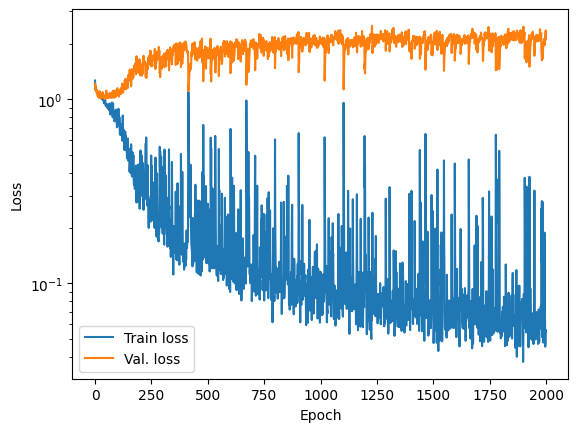

In [148]:
model = TransformerModel(input_size=whiteFeatures.shape[1], output_size=len(classes))
criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
# scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=50, gamma=0.1)
# nn.utils.clip_grad_norm_(model.parameters(), 1)

device = torch.device("cpu")
# device = torch.device("mps" if torch.backends.mps.is_built() else "cpu")
model.to(device)

nepoch = 2000

train_losses = []
val_losses = []

# for epoch in range(nepoch):
for epoch in tqdm(range(nepoch), leave=True, unit='epoch', desc= "Epochs"):
    
    total_train_loss = 0
    train_count = 0
    total_val_loss = 0
    val_count = 0
    
    for batch in train_loader:
        inputs, targets = batch['features'], batch['target']
        inputs, targets = inputs.to(device).detach(), targets.to(device).detach()
        # print(inputs)
        
        optimiser.zero_grad()
        outputs = model(inputs)
        
        train_loss = criterion(outputs, targets)
        train_loss.backward()
        optimiser.step()
        
        total_train_loss += train_loss.item()
        train_count += 1
    
    with torch.no_grad():
        for batch in val_loader:
            inputs, targets = batch['features'], batch['target']
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            
            val_loss = criterion(outputs, targets)
            
            total_val_loss += val_loss.item()
            val_count += 1
    
    train_losses.append(total_train_loss/train_count)
    val_losses.append(total_val_loss/val_count)
    # scheduler.step()

plt.semilogy(train_losses)
plt.semilogy(val_losses)
plt.legend(["Train loss", "Val. loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [149]:
print(train_losses[-1])
print(val_losses[-1])

0.054916020464657295
2.114527189731598


In [150]:
correct = 0
total = 0
true, pred = [], []

with torch.no_grad():
    for batch in test_loader:
        inputs, targets = batch['features'], batch['target']
        inputs, targets = inputs.to(device), targets.to(device)
        
        outputs = model(inputs)
        
        predicted = torch.argmax(outputs, dim=1)
        actual = torch.argmax(targets, dim=1)
        
        total += targets.size(0)
        correct += (predicted == actual).sum().item()
        
        true.append(actual)
        pred.append(predicted)
        
acc = 100 * correct / total


In [151]:
print(acc)

60.61224489795919


In [152]:
print(true[0])
print(pred[0])

tensor([3, 4, 8, 4, 6, 5, 5, 6, 5, 6, 5, 4, 6, 5, 5, 5, 3, 6, 5, 4, 4, 5, 5, 5,
        6, 3, 5, 5, 6, 5, 6, 5, 5, 4, 6, 5, 3, 4, 5, 5, 3, 4, 5, 5, 6, 6, 4, 6,
        4, 4, 5, 4, 5, 4, 3, 4, 5, 7, 4, 5, 4, 6, 6, 5])
tensor([3, 4, 5, 4, 6, 6, 5, 4, 6, 5, 4, 4, 5, 4, 4, 5, 3, 6, 5, 4, 4, 5, 5, 5,
        6, 4, 6, 5, 5, 4, 5, 4, 5, 4, 6, 5, 4, 4, 5, 5, 4, 4, 5, 5, 5, 5, 4, 6,
        4, 4, 5, 4, 5, 4, 4, 4, 5, 6, 4, 5, 4, 6, 6, 5])
